# Проект: Численные методы

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования:**
1. Построить модель для определения рыночной стоимости автомобиля, учитывая требования заказчика.

**Ход исследования**

Данные получим из файла `/datasets/autos.csv`, 

просмотрим общую информацию о датасете, оценим качество данных.

Далее приступим к предобработке данных: проверим и исправим ошибки, которые не приведут к искажению конечного результата, оценим их влияние на исследование. 

Затем настанет очередь исследовательского и корреляционного анализа данных.

После этого применим пайплайн для подготовки признаков и обучения моделей, одна из которых — LightGBM, как минимум одна — не бустинг.

Проанализируем время обучения, время предсказания и качество моделей.

Завершающим этапом исследования будет выбор лучшей модели и проверка на тестовой выборке.

Таким образом, иследование будет состоять из следующих этапов:

- [Обзор данных](#info)

- [Предобработка данных](#preprocessing)

- [Исследовательский анализ данных](#EDA)

- [Подготовка данных](#pipeline) 

- [Обучение модели](#model)

- [Анализ качества модели](#analysis)

- [Итоговые выводы](#final)

## Описание данных
Данные находятся в файле `/datasets/autos.csv`

| Признаки| |
| ------ | ------ | 
| **DateCrawled** | дата скачивания анкеты из базы| 
| **VehicleType** | тип автомобильного кузова|
| **RegistrationYear** | год регистрации автомобиля|
| **Gearbox** | тип коробки передач| 
| **Power** | мощность (л. с.)| 
| **Model** | модель автомобиля| 
| **Kilometer** | пробег (км)| 
| **RegistrationMonth** | месяц регистрации автомобиля| 
| **FuelType** | тип топлива| 
| **Brand** |марка автомобиля| 
| **Repaired** | была машина в ремонте или нет| 
| **DateCreated** | дата создания анкеты| 
| **NumberOfPictures** | количество фотографий автомобиля| 
| **PostalCode** | почтовый индекс владельца анкеты (пользователя)| 
| **LastSeen** | дата последней активности пользователя| 

| Целевой признак| |
| ------ | ------ | 
| **Price** |  цена (евро)| 


In [1]:
# Устанавливаем и обновляем необходимые библиотеки
!pip install -Uq scikit-learn phik 

In [2]:
!pip install -Uq --upgrade lightgbm

In [3]:
# Импротируем необходимые библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from numpy.random import RandomState
sns.set()

import sklearn
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    TargetEncoder,
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Зафиксируем случайность  и размер тестовой выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25
state = RandomState(12345)

sklearn.__version__, lightgbm.__version__


('1.6.1', '4.6.0')

### **Общая информация**
<a id='info'></a>

In [4]:
# Загружаем файл
pth1 = '/datasets/autos.csv'
pth2 = 'autos.csv'
    
if os.path.exists(pth1):
    autos = pd.read_csv(pth1)
elif os.path.exists(pth2):
    autos = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
# Создаем функцию для получения общей информации
def general_info(df):
    return df.info(), display(df.shape, df.head())

In [6]:
# Посмотрим на первые 5 строк каждого датасета и общую информацию
general_info(autos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

(354369, 16)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


(None, None)

**Вывод:** Датафрейм содержит **354369 строк и 16 столбцов**.

В данных присутствуют пропуски, типы данных корректны.

### **Предобработка данных**
<a id='preprocessing'></a>

#### **Пропущенные значения**

Определим, в каких столбцах есть пропуски.

In [7]:
# Проверим количество пропусков в процентах
pd.DataFrame(round(autos.isna().mean()*100,),).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


Пропуски категориальных значений в колонках `'VehicleType','Gearbox','FuelType','Repaired'` возможно полностью случайные. Вопрос не зависит от характера самого вопроса и от других вопросов. Обработаем эти пропуски в пайплане при подготовке данных.

#### **Явные и неявные дубликаты**

Проверим количество **явных** дубликатов в данных.

In [8]:
autos.duplicated().sum()

4

В таблице присутствуют явные дубликаты, удалим их.

In [9]:
autos = autos.drop_duplicates()

Проверим количество **неявных** дубликатов в данных.

In [10]:
# Выведем уникальные значения категориальных столбцов 
columns = autos.select_dtypes(exclude='number').columns.to_list()
for col in columns:
    display(col, autos[col].unique())

'DateCrawled'

array(['2016-03-24 11:52:17', '2016-03-24 10:58:45',
       '2016-03-14 12:52:21', ..., '2016-03-21 09:50:58',
       '2016-03-14 17:48:27', '2016-03-19 18:57:12'], dtype=object)

'VehicleType'

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

'Gearbox'

array(['manual', 'auto', nan], dtype=object)

'Model'

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

'FuelType'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

'Brand'

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

'Repaired'

array([nan, 'yes', 'no'], dtype=object)

'DateCreated'

array(['2016-03-24 00:00:00', '2016-03-14 00:00:00',
       '2016-03-17 00:00:00', '2016-03-31 00:00:00',
       '2016-04-04 00:00:00', '2016-04-01 00:00:00',
       '2016-03-21 00:00:00', '2016-03-26 00:00:00',
       '2016-04-07 00:00:00', '2016-03-15 00:00:00',
       '2016-03-11 00:00:00', '2016-03-20 00:00:00',
       '2016-03-23 00:00:00', '2016-03-27 00:00:00',
       '2016-03-12 00:00:00', '2016-03-13 00:00:00',
       '2016-03-18 00:00:00', '2016-03-10 00:00:00',
       '2016-03-07 00:00:00', '2016-03-09 00:00:00',
       '2016-03-08 00:00:00', '2016-04-03 00:00:00',
       '2016-03-29 00:00:00', '2016-03-25 00:00:00',
       '2016-03-28 00:00:00', '2016-03-30 00:00:00',
       '2016-03-22 00:00:00', '2016-02-09 00:00:00',
       '2016-03-05 00:00:00', '2016-04-02 00:00:00',
       '2016-03-16 00:00:00', '2016-03-19 00:00:00',
       '2016-04-05 00:00:00', '2016-03-06 00:00:00',
       '2016-02-12 00:00:00', '2016-03-03 00:00:00',
       '2016-03-01 00:00:00', '2016-03-04 00:0

'LastSeen'

array(['2016-04-07 03:16:57', '2016-04-07 01:46:50',
       '2016-04-05 12:47:46', ..., '2016-03-19 20:44:43',
       '2016-03-29 10:17:23', '2016-03-21 10:42:49'], dtype=object)

Неявные дубликаты отсутствуют.

#### Создание новых столбцов

На основе параметров с датами создадим новые столбцы, которые лучше помогут при анализе и обучении.

In [11]:
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'])
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'])
autos['LastSeen']    = pd.to_datetime(autos['LastSeen'])

# Посчитаем, сколько дней прошло между созданием и скачиванием
autos['DaysOnline'] = (autos['DateCrawled'] - autos['DateCreated']).dt.days

# Посчитаем, сколько дней объявление было активно
autos['DaysActive'] = (autos['LastSeen'] - autos['DateCreated']).dt.days

Определим регионы Германии по почтовому индексу и создадим новый столбец.

In [12]:
# Функция для категоризации
def german_regions(code):
    if len(str(code)) == 4:
        return 'East Germany'
    if str(code)[0] == '1':
        return 'Berlin'
    if str(code)[0] =='2':
        return 'North Germany'
    if str(code)[0] =='3':
        return 'Central Germany'
    if str(code)[0] =='4':
        return 'West (Ruhr Area)'
    if str(code)[0] =='5':
        return 'West (Rhine)'
    if str(code)[0] =='6':
        return 'Southwest (Hesse)'
    if str(code)[0] =='7':
        return 'Southwest (Baden-Württemberg)'
    if str(code)[0] =='8':
        return 'South (Bavaria)'
    if str(code)[0] =='9':
        return 'South (Bavaria, Baden-Württemberg)'
    else:
        return 'Other'

autos['Region'] = autos['PostalCode'].apply(german_regions)

# Удалим столбец с почтовыми индексами во избежание утечки данных
autos = autos.drop('PostalCode', axis=1)

**Вывод:** таким образом, мы обнаружили, в каких столбцах есть пропуски, добавили вспомогательные столбцы, удалили явные дубликаты и подтвердили отсутсвие неявных.

### **Исследовательский анализ данных**
<a id='EDA'></a>

#### **Статистический анализ количественных признаков**

In [13]:
# Выведем статистики количественных признаков
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,DaysOnline,DaysActive
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,0.086699,8.678058
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,2.135057,8.639415
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,0.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,0.000000,2.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,0.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,0.000000,13.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,737.000000,759.000000


В признаке `Price` среднее больше медианы, что говорит о больших выбросах справа. Такая ситуация для цен имеет место быть, потому что цены на элитные автомобили могут выбиваться из большинства и тянуть чувствительное к выбросам среднее вверх.

Аналогичная природа у среднего и медианы признака `Kilometer`.

В признаке `RegistrationYear` аномальное максимальное значение - 9999 и минимальное - 1000, такой год не соответствует реальности.

В признаке `RegistrationMonth` аномальное минимальное значение - 0, такого месяца не существует.

В признаке `Power` аномальное минимальное - 0 и максимальное 20000 значение.

Признак `NumberOfPictures` не информативен, все его значения равны нулю.

В остальных признаках среднее несильно отличается от медианы, максимальные и минимальные значения и аномальны.

In [14]:
# Посмотрим, когда была сделана последняя выгрузка объявления
autos['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [15]:
#Удалим аномальные значения и учтем, что выгрузка всех объявлений была произведена не позднее апреля 2016 года.
autos = autos[(autos['RegistrationYear'] >= 1900) & (autos['RegistrationYear'] <= 2016)]
autos = autos[autos['DateCreated'] <= '2016-04-07']
autos = autos[(autos['RegistrationYear'] < 2016) | ((autos['RegistrationYear'] == 2016) & (autos['RegistrationMonth'] <= 4))]
autos = autos[(autos['Power'] > 20) & (autos['Power'] < 400)]

In [16]:
#Удалим неинформативный столбец
autos = autos.drop('NumberOfPictures', axis=1)

Построим графики для количественных признаков: гистограмму частотности распределения и ящик с усами.

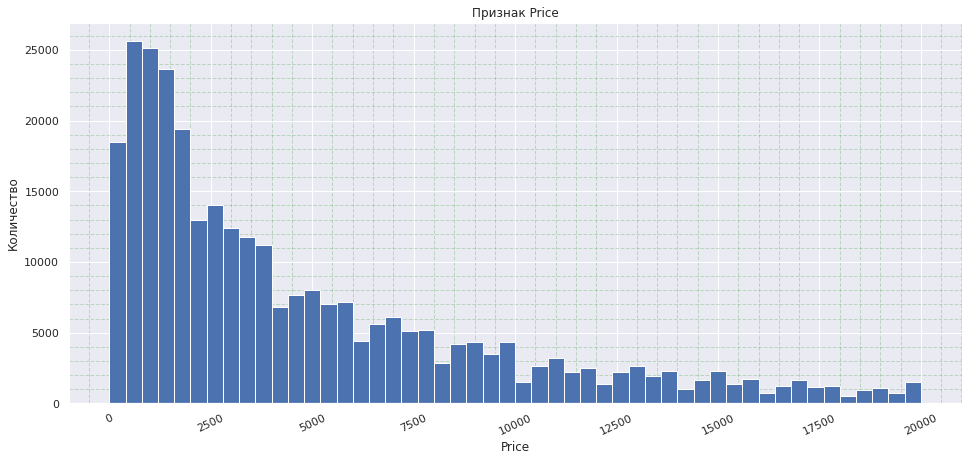

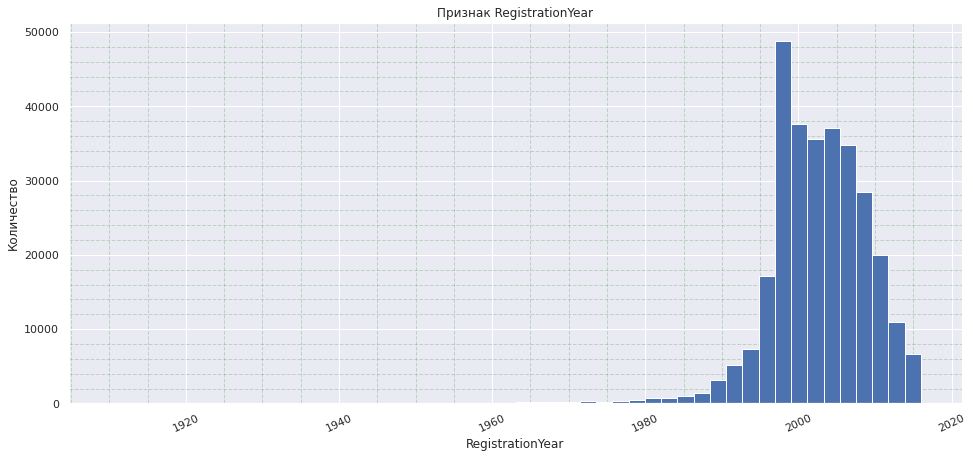

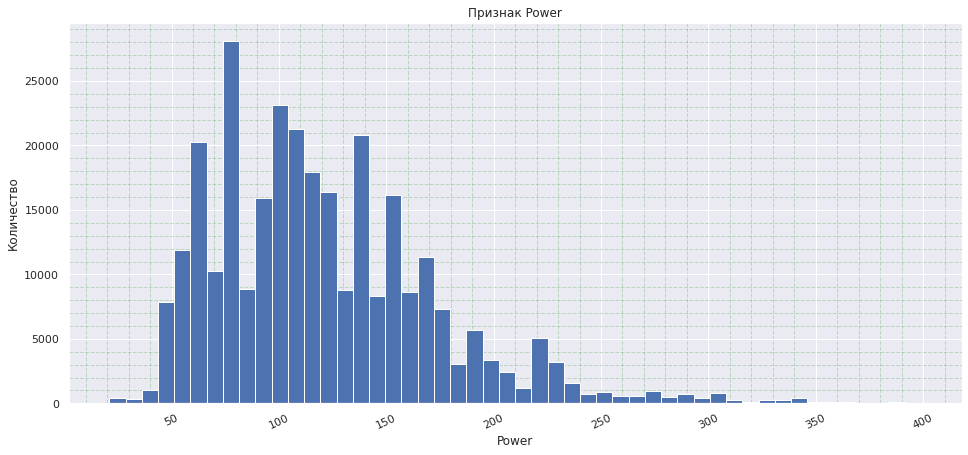

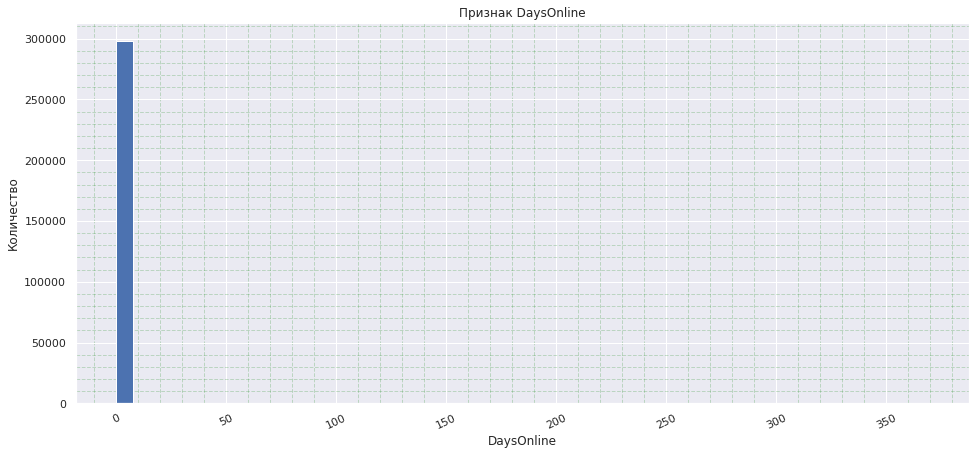

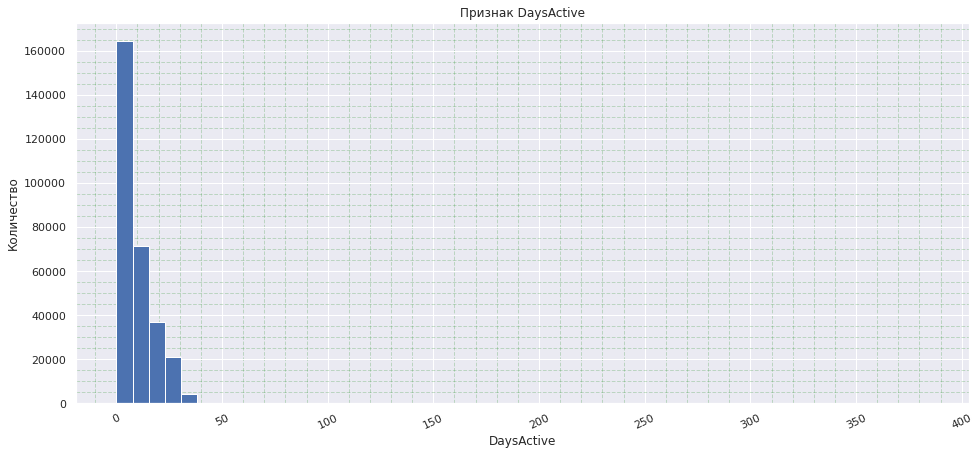

In [17]:
# Строим гистограмму
for col in autos.drop(['RegistrationMonth', 'Kilometer'], axis=1).select_dtypes(include='number').columns:
        plt.figure(figsize=(16,7))
        autos[col].hist(bins=50)
        plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
        plt.minorticks_on()
        plt.tick_params(which='minor')
        plt.xticks(rotation = 25)
        plt.title(f'Признак {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.show()

Признаки `DaysActive, DaysOnline` имеют сильные выбросы, это связано с особенностями параметров.

Остальные признаки не имеют сильных выбросов и аномалий.

Целевой `Price` - непрерывный, мы имеем дело с задачей регрессии.

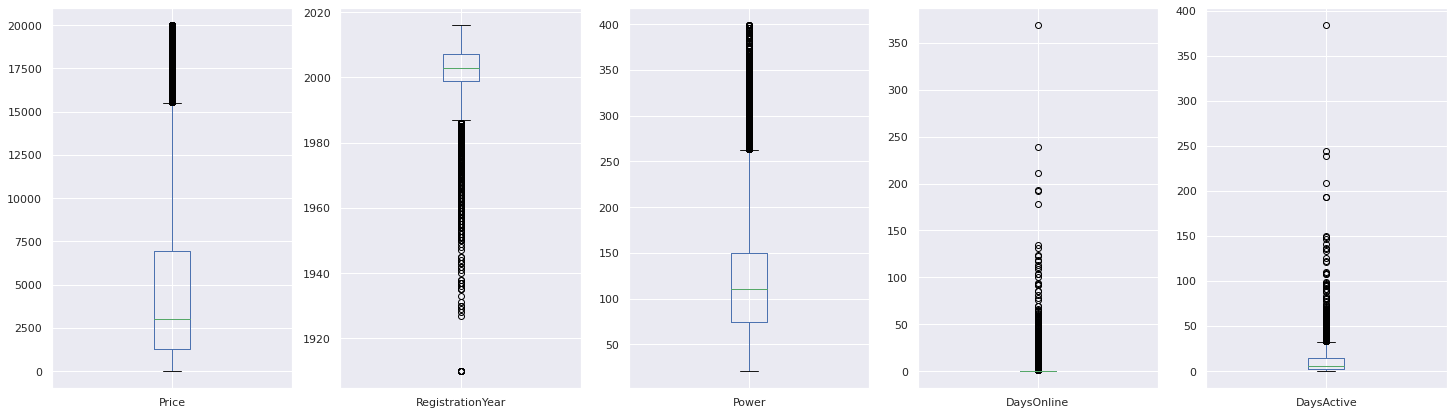

In [18]:
#Строим ящик с усами
autos.drop(['RegistrationMonth', 'Kilometer'], axis=1).plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(25, 7)
);

В признаках много выбросов сверху и снизу, это может быть связано со спецификой параметров.

Построим распределение дискретных признаков `RegistrationMonth и Kilometer`.

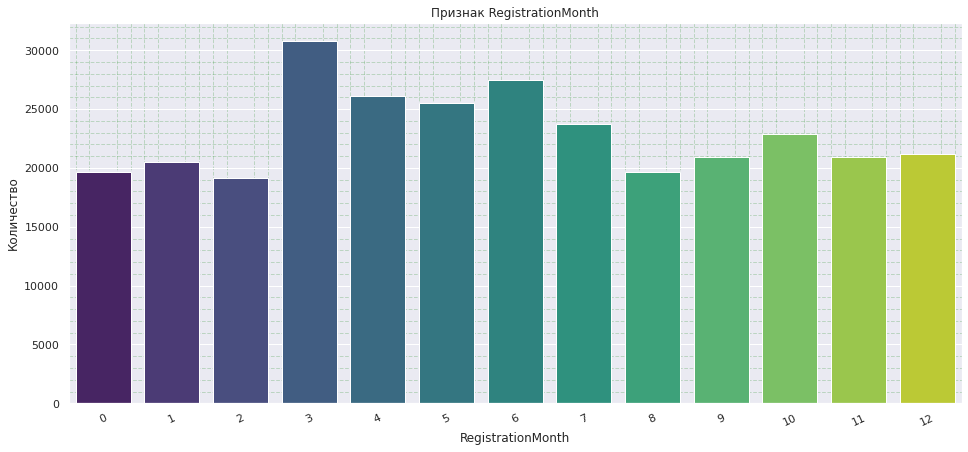

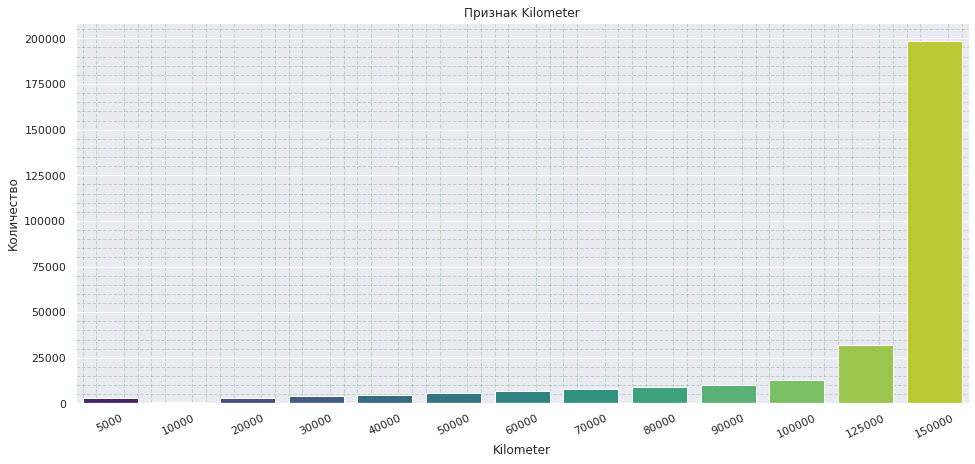

In [19]:
for col in autos[['RegistrationMonth', 'Kilometer']].columns:
        plt.figure(figsize=(16,7))
        sns.countplot(x=col, data=autos, palette='viridis')
        plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
        plt.minorticks_on()
        plt.tick_params(which='minor')
        plt.xticks(rotation = 25)
        plt.title(f'Признак {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.show()

Машины преимущественно были зарегестрированы в марте, а самый популярный пробег - 150 000.

#### **Статистический анализ категориальных признаков**

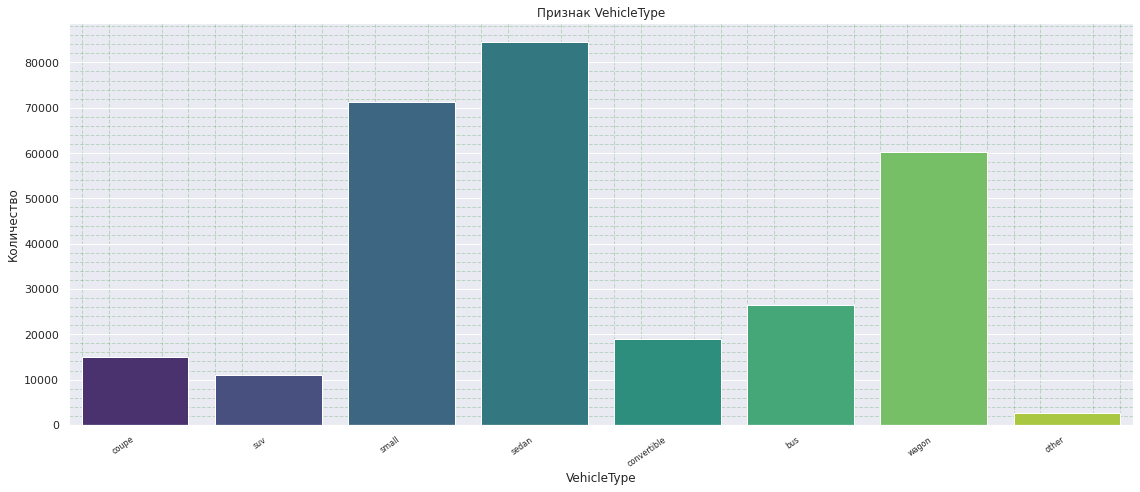

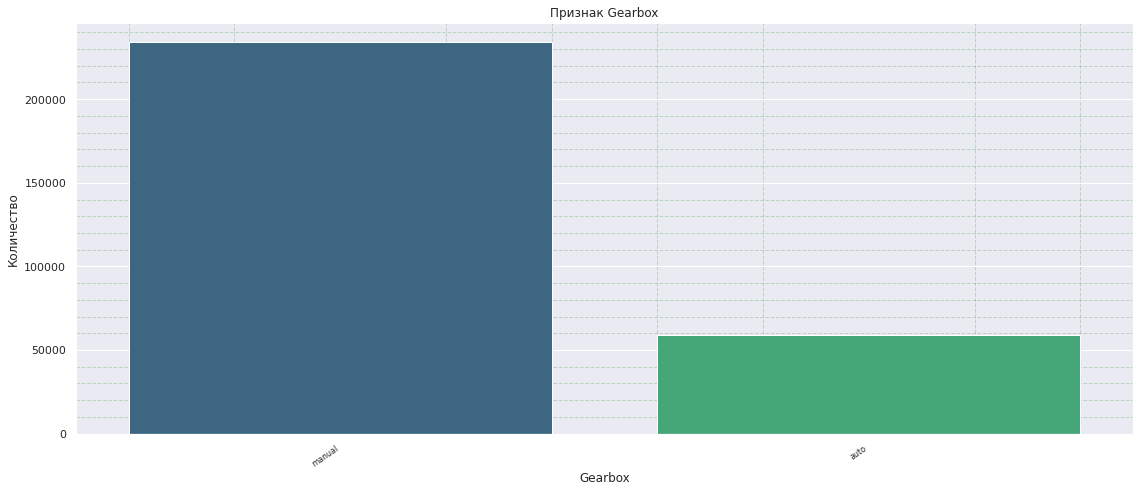

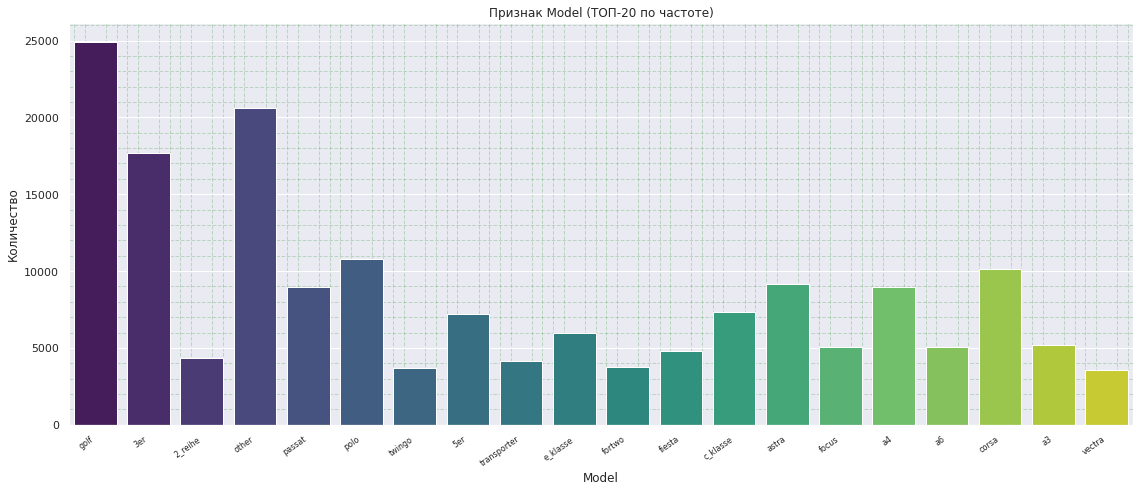

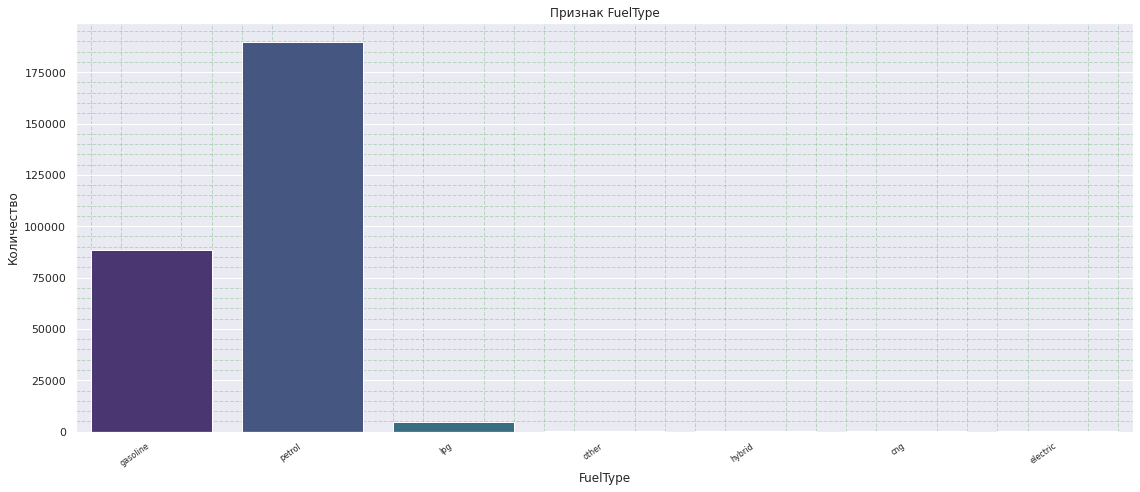

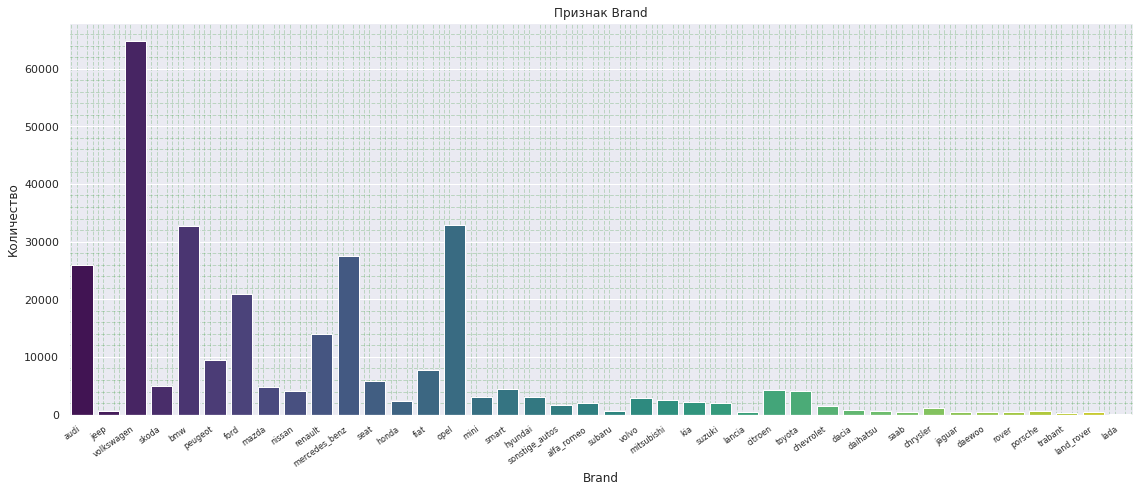

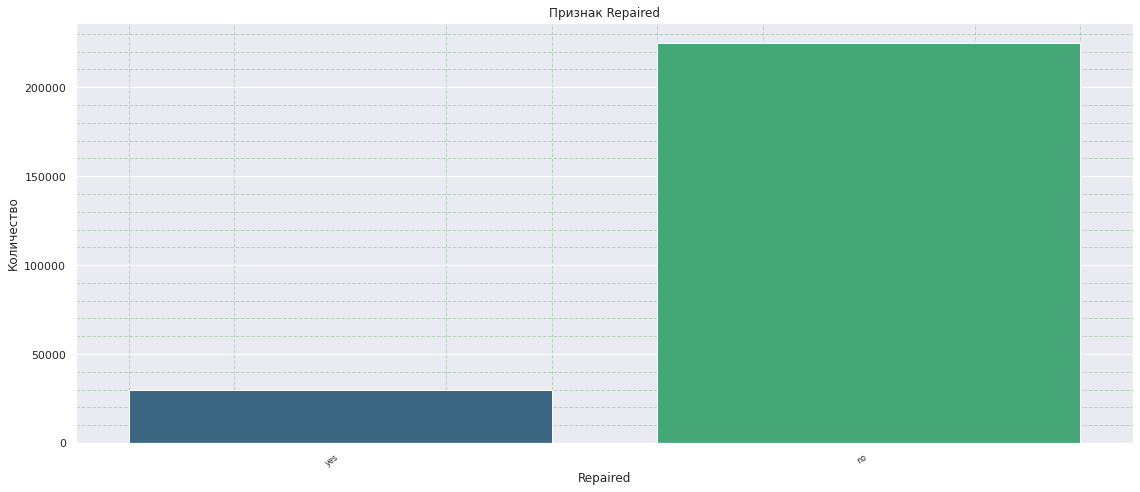

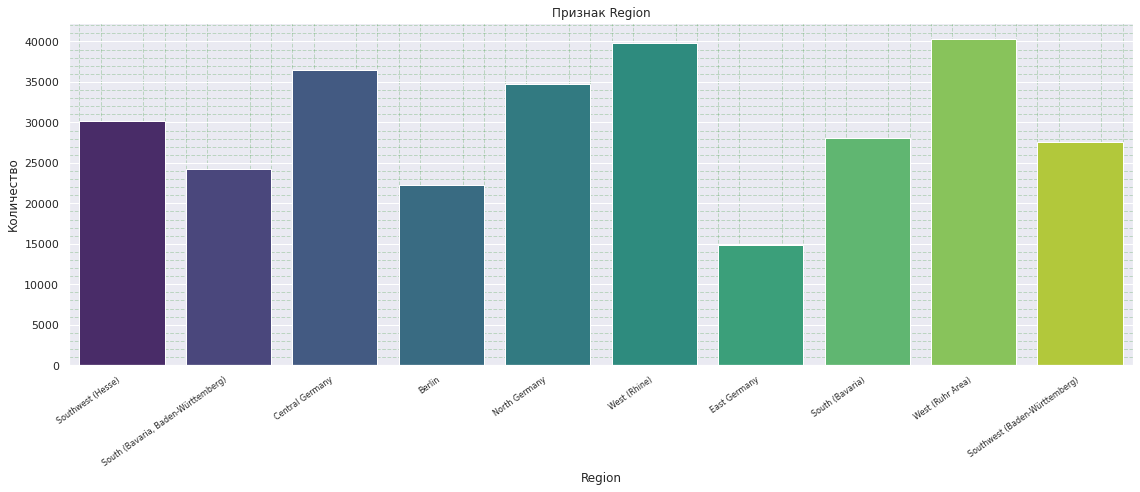

In [20]:
# Строим столбчатую диаграмму для каждого категориального столбца 
for col in autos.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(16, 7))
    
    if col == 'Model':
        top_models = autos[col].value_counts().head(20).index
        data_filtered = autos.query('Model in @top_models')
        
        sns.countplot(
            x=col,
            data=data_filtered,
            palette='viridis'
        )
        plt.title(f'Признак {col} (ТОП-20 по частоте)')
    else:
        sns.countplot(x=col, data=autos, palette='viridis')
        plt.title(f'Признак {col}')

    plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor')
    plt.xticks(rotation=35, ha='right', fontsize=8)
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.tight_layout()  
    plt.show()

Мы видим, что

- популярный тип автомобильного кузова седан;

- ручная КПП в 4 раза преобладает над автоматической;

- тип топлива чаще всего бензин;

- популярный бренд - Volkswagen;

- большинство объявлений опубликовано в северной и западной Германии;

- большая часть машин не была в ремонте.

#### **Корреляционный анализ признаков**

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками и построим тепловую карту.

In [21]:
# Вычисление матрицы корреляции 
autos = autos.drop(['LastSeen', 'DateCrawled', 'DateCreated'], axis=1)
corr = autos.phik_matrix(interval_cols=['Price','RegistrationYear','Power',
                                        'NumberOfPictures', 'DaysOnline', 'DaysActive'])

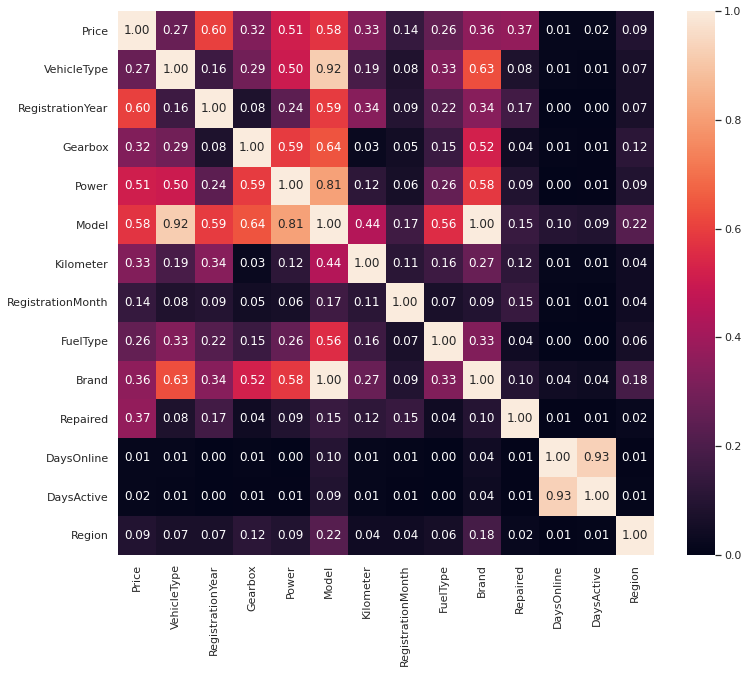

In [22]:
# Построение тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f');

Мы наблюдаем заметную прямую связь между целевым признаком и `RegistrationYear, Model`, умеренную прямую связь между целевым и `GearBox, Power, Kilometer, Brand, Repaired`, а также слабую прямую связь между целевым и `VehicleType, RegistrationMonth, FuelType, PostalCode, DaysOnline, DaysActive`.

**Мультиколлинеарность** между входными признаками **наблюдается** коэффициент корреляции от 0.9 до 0.95 по модулю присутвует между признаками `Model и VehicleType`, `DaysOnline и DaysActive`, `Brand и Model`. Удалим по одному признаку из каждой пары. 

In [23]:
#Удалим признаки с мультиколлинеарностью
autos = autos.drop(['VehicleType', 'DaysOnline','Brand'], axis=1)

Посмотрим на взаимосвязь между целевым признаком и входными. Построим диаграммы рассеяния для признака `Price` и всех количественных признаков.

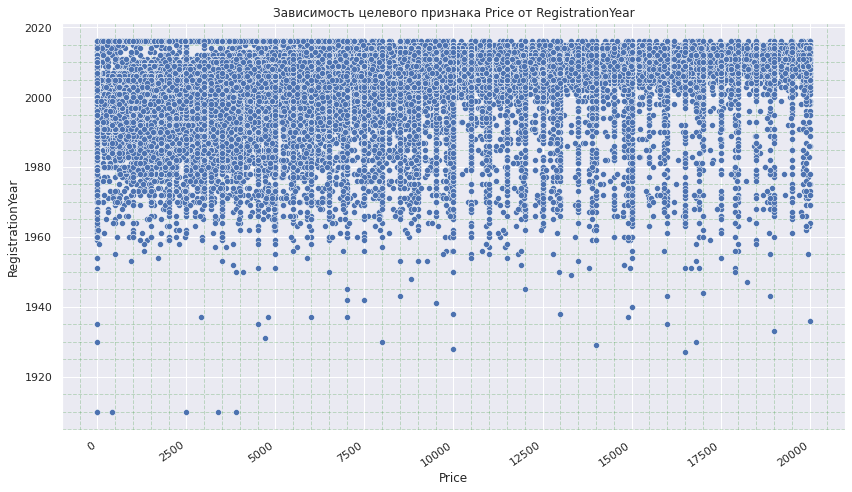

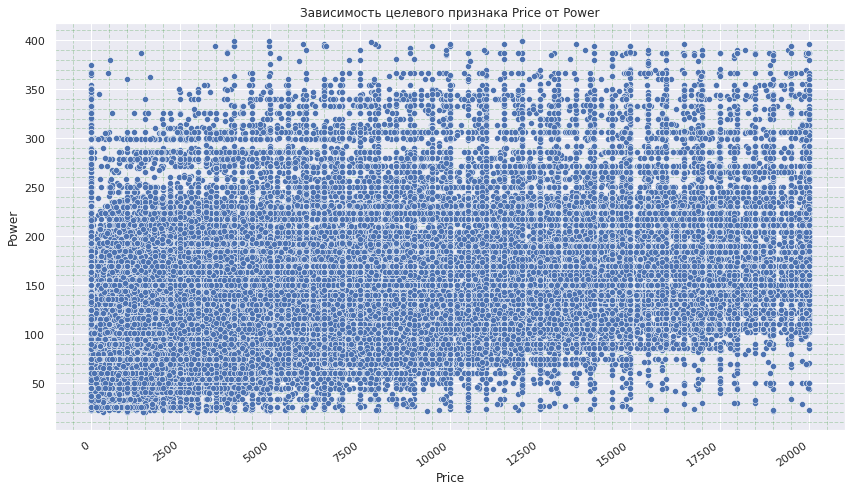

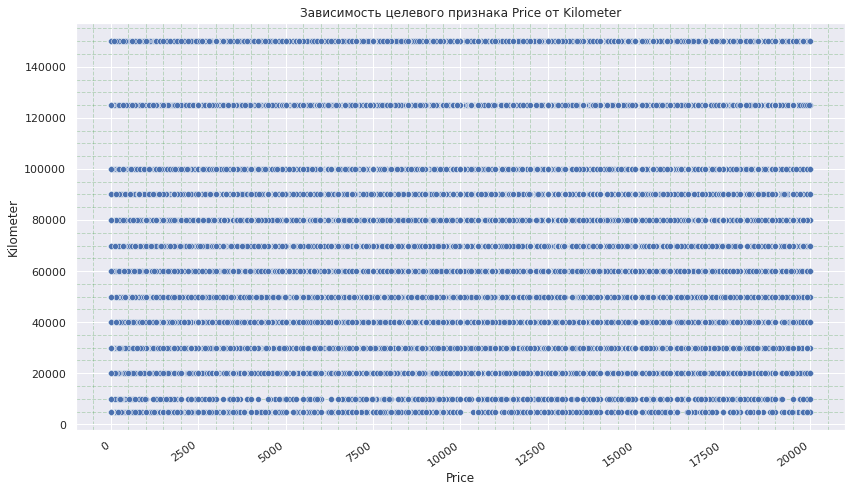

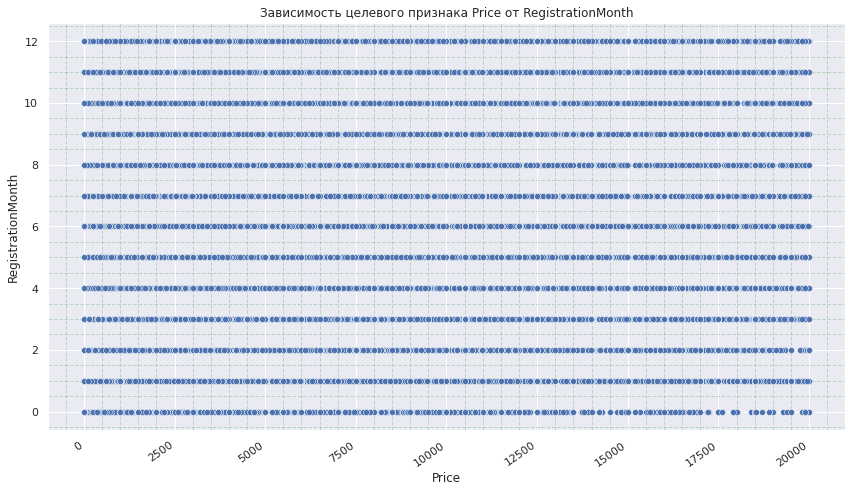

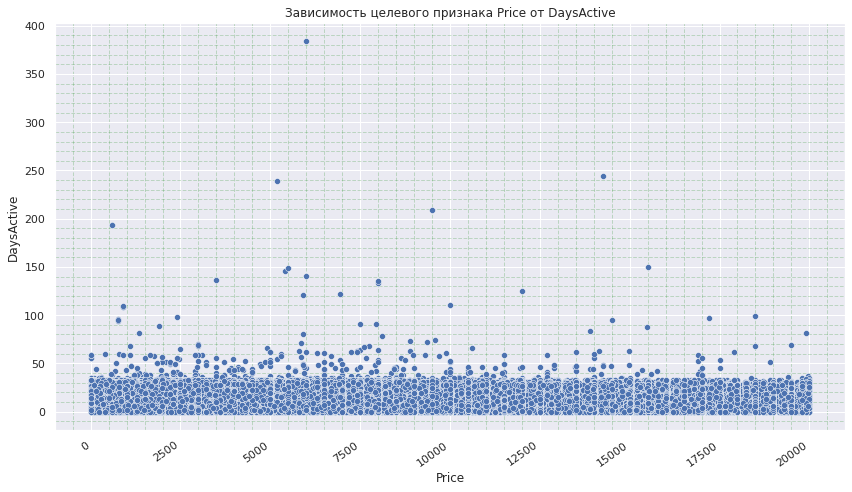

In [24]:
for col in autos.select_dtypes(include=['int','float']).columns:
        if col not in ['Price']:
            plt.figure(figsize=(12,7))
            sns.scatterplot(data=autos, x='Price', y=col)
            plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
            plt.minorticks_on()
            plt.tick_params(which='minor')
            plt.xticks(rotation=35, ha='right')
            plt.xlabel('Price')
            plt.ylabel(col)
            plt.title(f'Зависимость целевого признака Price от {col}')
            plt.tight_layout()  
            plt.show();

Параметры имеют линейную зависимость между входными и целевым признаком, что скажется на качестве модели линейной регрессии.

**Вывод:** таким образом, мы провели статистический анализ количественных и категориальных признаков, а также корреляционный анализ. Аномальные значения обнаружены и удалены, мультиколлинеарность между входными признаками устранена, связь между целевым и входными признаками изучена.

### **Подготовка данных**
<a id='pipeline'></a>

Подготовим данные, количественные и категориальные признаки обработаем в пайплайне.

In [25]:
# Создаём списки с названиями признаков
cat_columns = ['Gearbox', 'Model', 'FuelType', 'Repaired', 'Region']
num_columns = ['RegistrationYear', 'Power', 'DaysActive', 'RegistrationMonth', 'Kilometer']

# Кодируем категориальные значения
cat_pipe = Pipeline(
    [
        (
            'simpleImputer_cat', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'cat', 
            TargetEncoder(target_type='continuous', smooth=10,  random_state=RANDOM_STATE)
        )
    ]
)

# Создаём пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, cat_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Создаём итоговый пайплайн для модели регрессии: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

pipe_final.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   TargetEncoder(random_state=42,
                                                                                 smooth=10,
                                                                                 target_type='continuous'))]),
                                                  ['Gearbox', 'Model',
                                                   'FuelType', 'Repaired',
                                                   'Region']),
                                                 ('num', MinMaxScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'DaysActive',
                                                   'RegistrationMonth',
                                                   'Kilometer'])])),
                ('models', LinearRegression())])

Разобьем данные на обучающую и тестовую выборки.

In [26]:
X, y = autos.drop(['Price'], axis=1), autos['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [27]:
# Проверим разбиение 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((223964, 10), (223964,), (74655, 10), (74655,))

**Вывод:** таким образом, мы подготовили данные для дальнейшего обучения на них моделей.

### **Обучение модели**
<a id='model'></a>

Напишем словарь для подбора лучших гиперпараметров.

In [28]:
param_grid = [
    # словарь для модели LinearRegression() 
    {
        'models':[LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модель LGBMRegressor()
    {
        'models':[LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)],
        'models__n_estimators': [50, 100],
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__max_depth': [3, 5, 7]
    },
    
    # словарь для модели CatBoostRegressor()
    {
        'models':[CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': [50, 100],
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__max_depth': [3, 5, 7]
    }
    
]

Используем пайплайн и инструмент подбора гиперпараметров, чтобы выбрать лучшую модель. 

В качестве метрики возьмем RMSE.


In [29]:
# Производим подбор гиперпараметров с помощью RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=15,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('simpleImputer_cat',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('cat',
                                                                                                TargetEncoder(random_state=42,
                                                                                                              smooth=10,
                                                                                                              target_type='continuous'))]),
                                                                               ['Gearbox',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'Repaired',
                                                                                'Region']),
                                                                              ('num',
                                                                               MinMaxSc...
                                        {'models': [LGBMRegressor(random_state=42,
                                                                  verbosity=-1)],
                                         'models__learning_rate': [0.01, 0.1,
                                                                   0.2],
                                         'models__max_depth': [3, 5, 7],
                                         'models__n_estimators': [50, 100]},
                                        {'models': [<catboost.core.CatBoostRegressor object at 0x7f9227711c70>],
                                         'models__iterations': [50, 100],
                                         'models__learning_rate': [0.01, 0.1,
                                                                   0.2],
                                         'models__max_depth': [3, 5, 7]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [30]:
results_df = pd.DataFrame(randomized_search.cv_results_)[['rank_test_score',
                                                          'param_models',
                                                          'mean_test_score',
                                                          'params',
                                                          'mean_fit_time',
                                                          'mean_score_time']].sort_values('rank_test_score')

**Вывод:** таким образом, мы обучили несколько моделей и составили топ-15 с характеристиками качества, времени обучения и времени предсказания.

### **Анализ качества модели**
<a id='analysis'></a>

Посмотрим на топ-15 обученных моделей:

In [31]:
results_df

,rank_test_score,param_models,mean_test_score,params,mean_fit_time,mean_score_time
0,1,"LGBMRegressor(random_state=42, verbosity=-1)",-1820.883726,"{'models__n_estimators': 100, 'models__max_dep...",1.609601,0.293073
8,2,<catboost.core.CatBoostRegressor object at 0x7...,-1833.853893,"{'models__max_depth': 7, 'models__learning_rat...",3.938115,0.093151
2,3,"LGBMRegressor(random_state=42, verbosity=-1)",-1836.831979,"{'models__n_estimators': 100, 'models__max_dep...",1.810725,0.359811
12,4,"LGBMRegressor(random_state=42, verbosity=-1)",-1860.691614,"{'models__n_estimators': 100, 'models__max_dep...",1.719959,0.308294
5,5,"LGBMRegressor(random_state=42, verbosity=-1)",-1919.317446,"{'models__n_estimators': 50, 'models__max_dept...",1.277014,0.186396
6,6,<catboost.core.CatBoostRegressor object at 0x7...,-1957.583611,"{'models__max_depth': 3, 'models__learning_rat...",3.057798,0.091150
7,7,<catboost.core.CatBoostRegressor object at 0x7...,-1960.562176,"{'models__max_depth': 7, 'models__learning_rat...",2.504140,0.087258
1,8,"LGBMRegressor(random_state=42, verbosity=-1)",-1979.744768,"{'models__n_estimators': 50, 'models__max_dept...",1.077913,0.145769
3,9,<catboost.core.CatBoostRegressor object at 0x7...,-2028.084873,"{'models__max_depth': 5, 'models__learning_rat...",2.354185,0.094189
14,10,<catboost.core.CatBoostRegressor object at 0x7...,-2041.785889,"{'models__max_depth': 3, 'models__learning_rat...",3.129558,0.089829


Мы видим, что самая лучшая модель по качеству - LGBMRegressor(learning_rate=0.2, max_depth=5), ее **RSME = 1821**.

Она же не самая быстрая, но не уступает по времени обучения и предсказания - **1,5 и 0.3 секунды.**

Нам необходимо подобрать оптимальный баланс между временем обучения, предсказания и качеством. Поэтому давайте обратим внимание на остальные модели в списке.

Хорошие показатели у модели на 2 месте CatBoostRegressor(learning_rate=0.2, max_depth=7), ее **RSME = 1834**, что ненамного хуже лучшей модели по качетсву и входит в порог, обозначенный заказчиком. Время предсказания у нее в 3,6 раза больше, чем у лучшей - 0.08 секунд. Но время обучения такой модели - **3.8 секунды**, она сильно проигрывает в этом модели на 1 месте.

Будем использовать модель LGBMRegressor(learning_rate=0.2, max_depth=5), ее параметры сбалансированы относительно критериев заказчика: и оптимальное качество(1821), и оптимальное время обучения(1,5 с) и предсказания(0.3 с).

Проверим качество выбранной модели на тестовой выборке.

In [32]:
y_test_pred = randomized_search.best_estimator_.predict(X_test)
print(f'Метрика RSME на тестовой выборке: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

Метрика RSME на тестовой выборке: 1855.943605010123


Метрика удовлетворяет требованиям заказчика. Проанализируем остатки.

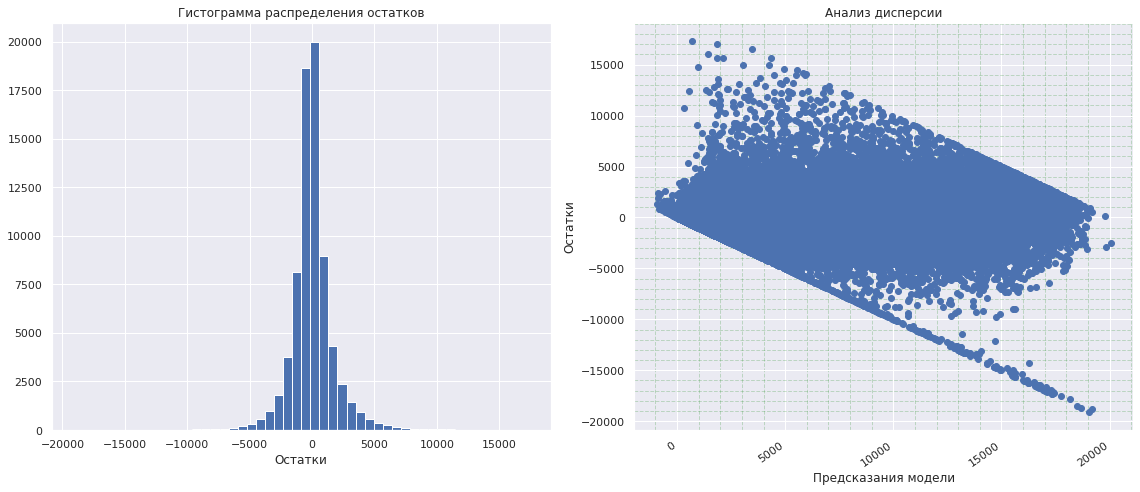

In [33]:
residuals = y_test-y_test_pred

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_test_pred, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()  
plt.show();

На гисторграмме график симметричен относительно нуля, значит среднее значение остатков модели равно 0. 
Модель даёт как завышенные, так и заниженные предсказания, которые «уравновешивают» друг друга. Такая модель работает качественно.

Дисперсия примерно равномерная, нет явного увеличения дисперсии при больших предсказаниях.Это говорит о высоком качестве модели, поскольку она равномерно ошибается.

**Вывод:** таким образом, мы проанализировали время обучения, время предсказания и качество моделей и, опираясь на критерии заказчика, выбрали лучшую модель.

### **Итоговые выводы**
<a id='final'></a>

Таким образом мы выбрали лучшую модель для сервиса по продаже автомобилей с пробегом «Не бит, не крашен»:

1. Построили модель для определения рыночной стоимости автомобиля, учитывая требования заказчика.

Для этого были выполнены следующие действия:

- **Открыт файл** с данными и изучена общая информация: 

**`/datasets/autos.csv`** содержал **354369 строк и 16 столбцов.**.


В данных присутсвовали пропуски, типы данных корректны.


- Выполнена **предобработка данных:**
    
    обработали явные и неявные дубликаты и устранили;
    изучили пропущенные значения, которые устранили в пайплайне;
    создали вспомогательные столбцы.


- Провели **исследовательский анализ данных:**

  проверили аномальные значения и посмотрели на распределение количественных и категориальных признаков;
  
  провели корреляционный анализ.
  

- Применили пайплайны для подготовки признаков и обучения модели:

    перебирали гиперпараметры для моделей линейной регрессии и градиентного бустинга

- Выбрали лучшую модель, учитывая критерии заказчика: качество предсказания, скорость предсказания, время обучения:

    **LGBMRegressor(learning_rate=0.2, max_depth=5), RMSE = 1856, время обучения = 1.5, время предсказания = 0.3**.
    
    
**Рекомендации для бизнеса:** 

Использовать модель у которой оптимальная комбинация параметров, соответсвующим критериям.

